# Image Classification

Name: Harmohinder Singh Gandhi

In [ ]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from bs4 import BeautifulSoup
import string

In [ ]:
# Paths
train_csv_path = 'X_train_update.csv'
test_csv_path = 'X_test_update.csv'
y_train_csv_path = 'Y_train.csv'
image_train_dir = 'images/image_train'
image_test_dir = 'images/image_test'

In [ ]:
# Load data
df_train = pd.read_csv(train_csv_path)
df_test = pd.read_csv(test_csv_path)
df_target = pd.read_csv(y_train_csv_path)

In [ ]:
df_tmp = df_train.merge(df_target, left_index=True, right_index=True)

## Exploratory Data Analysis

### Basic overview

In [ ]:
df_tmp.head()

,designation,description,productid,imageid,prdtypecode
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,10
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,2280
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,1280
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,2705


### 2.2 Class distribution

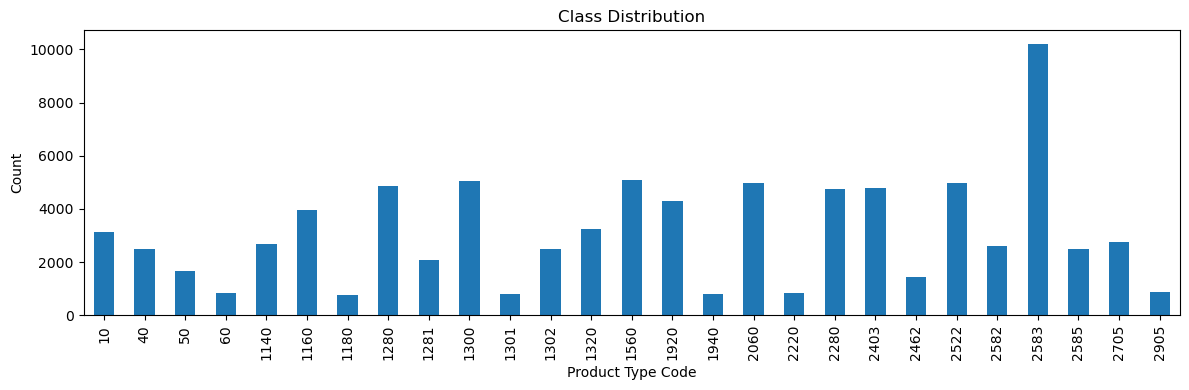

In [ ]:
class_counts = df_tmp['prdtypecode'].value_counts().sort_index()
plt.figure(figsize=(12,4))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Product Type Code')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### 2.3 Text length distribution

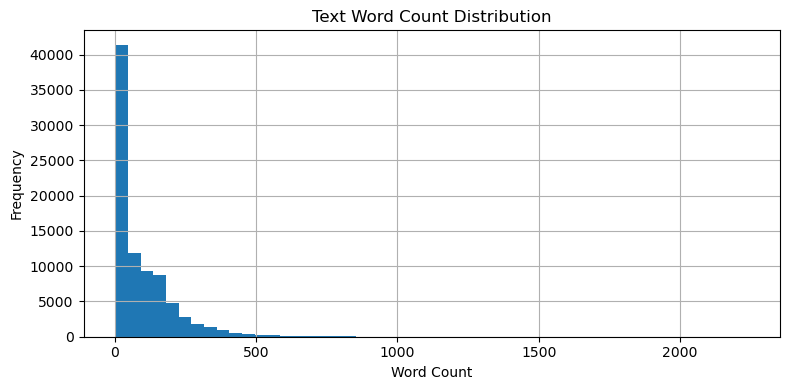

In [ ]:
# Merge designation and description
def clean_text(text):
    text = re.sub(r'<[^>]+>', ' ', str(text))
    text = re.sub(r"[^\w\s\.,'-]", ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_tmp['text'] = (df_tmp['designation'].fillna('') + ' ' + df_tmp['description'].fillna('')).apply(clean_text)

df_tmp['word_count'] = df_tmp['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,4))
df_tmp['word_count'].hist(bins=50)
plt.title('Text Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
# Histogram text representation
bins = np.histogram_bin_edges(df_tmp['word_count'], bins=50)
hist, bin_edges = np.histogram(df_tmp['word_count'], bins=bins)

print("Text Word Count Distribution (Binned)")
print("--------------------------------------")
for i in range(len(hist)):
    bin_range = f"{int(bin_edges[i])}–{int(bin_edges[i+1])}"
    count = hist[i]
    bar = '▇' * (count // 50)
    print(f"{bin_range:<10} | {count:>5}")


Text Word Count Distribution (Binned)
--------------------------------------
2–46       | 41361
46–91      | 11807
91–136     |  9381
136–181    |  8772
181–225    |  4749
225–270    |  2732
270–315    |  1819
315–360    |  1339
360–405    |   916
405–449    |   590
449–494    |   352
494–539    |   252
539–584    |   193
584–628    |   134
628–673    |    98
673–718    |    81
718–763    |    38
763–808    |    53
808–852    |    43
852–897    |    30
897–942    |    27
942–987    |    26
987–1031   |    27
1031–1076  |    19
1076–1121  |    10
1121–1166  |     8
1166–1211  |     5
1211–1255  |    16
1255–1300  |     5
1300–1345  |     3
1345–1390  |     8
1390–1434  |     2
1434–1479  |     5
1479–1524  |     6
1524–1569  |     3
1569–1614  |     1
1614–1658  |     1
1658–1703  |     1
1703–1748  |     2
1748–1793  |     0
1793–1837  |     0
1837–1882  |     0
1882–1927  |     0
1927–1972  |     0
1972–2017  |     0
2017–2061  |     0
2061–2106  |     0
2106–2151  |     0
2151–2196  

## Text Preprocessing

In [ ]:
print("Train dataset shape:")
print(df_train.shape)
print("Test dataset shape:")
print(df_test.shape)

Train dataset shape:
(84916, 5)
Test dataset shape:
(13812, 5)


In [ ]:
df_train.head()

,Unnamed: 0,designation,description,productid,imageid
0,0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786


In [ ]:
df_target.head()

,Unnamed: 0,prdtypecode
0,0,10
1,1,2280
2,2,50
3,3,1280
4,4,2705


In [ ]:
df_train['description'] = df_train['description'].fillna("")
df_train['text'] = df_train['designation'] + " " + df_train['description']

df_test['description'] = df_test['description'].fillna("")
df_test['text'] = df_test['designation'] + " " + df_test['description']

In [ ]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = BeautifulSoup(text, "html.parser").get_text()
    # remove metric units cm, kg, etc
    text = re.sub(r'\b\d+(?:\.\d+)?\s?(?:[a-zA-Z%]{1,3}(?:[/.][a-zA-Z]{1,2})?)\b', ' ', text)
    # remove units like Axx, N°
    text = re.sub(r'\bA\d+\b|\bN°?\s\d+\b', '', text)
    # remove unnecessary special chars
    text = re.sub(r'[^a-zA-Z\s\'À-ÿäöüÄÖÜß]', ' ', text, flags=re.UNICODE)
    # remove symbol 'Ø'
    text = re.sub(r'\s[Ø]\s', ' ', text, flags=re.UNICODE)
    # remove dimensions " X " or " x "
    text = re.sub(r'\s[×xX]\s', ' ', text)
    # remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation)) 
    # lowercase
    text = text.lower()
    # remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip() 
    return text

In [ ]:
df_train['text'] = df_train['text'].apply(clean_text)
df_test['text'] = df_test['text'].apply(clean_text)


/tmp/ipykernel_3010/1410644686.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [ ]:
# image_998492573_product_334573850.jpg
# Construct matching image filenames
df_train['imagename'] = "image_" + df_train["imageid"].astype(str) + "_product_" + df_train["productid"].astype(str) + ".jpg"
df_test['imagename'] = "image_" + df_test["imageid"].astype(str) + "_product_" + df_test["productid"].astype(str) + ".jpg"

In [ ]:
# Drop unneeded columns
df_train.drop(['description', 'designation', 'imageid', "productid"], axis=1, inplace=True)
df_test.drop(['description', 'designation', 'imageid', "productid"], axis=1, inplace=True)

In [ ]:
# Compute character and word lengths
df_train['len_char'] = df_train['text'].apply(len)
df_train['len_word'] = df_train['text'].apply(lambda x: len(re.findall(r"\b\w+(?:'w+)?\b", x)))

df_test['len_char'] = df_test['text'].apply(len)
df_test['len_word'] = df_test['text'].apply(lambda x: len(re.findall(r"\b\w+(?:'w+)?\b", x)))

In [ ]:
# Combine train data with target variable and save to csv
df_preprocessed_train = df_train.merge(df_target, left_index=True, right_index=True)

df_preprocessed_train.to_csv("preprocessed_train.csv")
df_test.to_csv("preprocessed_test.csv")

## Image Preprocessing

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 # pip install opencv-python
import numpy as np

In [ ]:
df = pd.read_csv('preprocessed_train.csv')
# df_target = pd.read_csv('Y_train.csv')

In [ ]:
# Load previously saved ratios if available
ratios_file = "preprocessed_train_img_ratios.csv"
if os.path.exists(ratios_file):
    df_ratios = pd.read_csv(ratios_file)
    processed_images = set(df_ratios['imagename'])
    img_ratios = df_ratios.set_index('imagename')['img_ratios'].to_dict()
else:
    processed_images = set()
    img_ratios = {}


In [ ]:
len(df['prdtypecode'].unique())

27

In [ ]:
input_dir = "images/image_train"
output_dir = "images/image_train_cropped"

os.makedirs(output_dir, exist_ok=True)

# Initialize img_ratios as a dictionary
img_ratios = {}

for _, row in df.iterrows():
  thefile = row['imagename']

  if thefile in processed_images:
      continue  # skip processed images

  input_path = os.path.join(input_dir, thefile)
  output_path = os.path.join(output_dir, thefile)

  img = cv2.imread(input_path)

  if img is None:
      print(f"Image not found: {thefile}")
      # Append to the dictionary with a key
      img_ratios[thefile] = np.nan
      continue

  height, width = img.shape[:2]
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

  contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  if not contours:
      print(f"Content not found: {thefile}")
      # Append to the dictionary with a key
      img_ratios[thefile] = 0.0
      cv2.imwrite(output_path, img)

  else:
    # bounding box
    x, y, width_box, height_box = cv2.boundingRect(np.concatenate(contours))

    cropped = img[y:y+height_box, x:x+width_box]

    area_content = width_box * height_box
    area_original = width * height
    ratio = area_content / area_original
    # Append to the dictionary with a key
    img_ratios[thefile] = ratio

    # 10 is border size, 224 is desired size
    target_size = 224 - (2 * 10)

    # resize
    scale = min(target_size / width_box, target_size / height_box)
    new_width = int(width_box * scale)
    new_height = int(height_box * scale)
    resized = cv2.resize(cropped, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # padding
    pad_top = (target_size - new_height) // 2
    pad_bottom = target_size - new_height - pad_top
    pad_left = (target_size - new_width) // 2
    pad_right = target_size - new_width - pad_left

    padded = cv2.copyMakeBorder(resized, pad_top+10 , pad_bottom+10 , pad_left+10 , pad_right+10, borderType=cv2.BORDER_CONSTANT, value=[255, 255, 255])

    cv2.imwrite(output_path, padded)

  # Save progress every 100 images
  if len(img_ratios) % 100 == 0:
      temp_df = pd.DataFrame(list(img_ratios.items()), columns=['imagename', 'img_ratios'])
      temp_df.to_csv(ratios_file, index=False)
      print(f"Checkpoint saved: {len(img_ratios)} images processed")

Checkpoint saved: 100 images processed
Checkpoint saved: 200 images processed
Checkpoint saved: 300 images processed
Checkpoint saved: 400 images processed
Checkpoint saved: 500 images processed
Checkpoint saved: 600 images processed
Checkpoint saved: 700 images processed
Checkpoint saved: 800 images processed
Checkpoint saved: 900 images processed
Checkpoint saved: 1000 images processed
Checkpoint saved: 1100 images processed
Checkpoint saved: 1200 images processed
Checkpoint saved: 1300 images processed
Checkpoint saved: 1400 images processed
Checkpoint saved: 1500 images processed
Checkpoint saved: 1600 images processed
Checkpoint saved: 1700 images processed
Checkpoint saved: 1800 images processed
Checkpoint saved: 1900 images processed
Checkpoint saved: 2000 images processed
Checkpoint saved: 2100 images processed
Checkpoint saved: 2200 images processed
Checkpoint saved: 2300 images processed
Checkpoint saved: 2400 images processed
Checkpoint saved: 2500 images processed
Checkpoin

In [ ]:
# Final save
df['img_ratios'] = df['imagename'].map(img_ratios)
df.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1, errors='ignore', inplace=True)
df.to_csv(ratios_file, index=False)

In [ ]:
df.head()

,Unnamed: 0,text,imagename,len_char,len_word,prdtypecode,img_ratios
0,0,olivia personalisiertes notizbuch seiten punkt...,image_1263597046_product_3804725264.jpg,72,9,10,0.118976
1,1,journal des arts le n lart et son marche salon...,image_1008141237_product_436067568.jpg,172,31,2280,0.188640
2,2,grand stylet ergonomique bleu gamepad nintendo...,image_938777978_product_201115110.jpg,729,116,50,0.505352
3,3,peluche donald europe disneyland marionnette à...,image_457047496_product_50418756.jpg,52,7,1280,0.512820
4,4,la guerre des tuques luc a des idées de grande...,image_1077757786_product_278535884.jpg,201,38,2705,0.219128


In [ ]:
avg_ratios = df.groupby("prdtypecode")["img_ratios"].mean().sort_values(ascending=False)
print(avg_ratios)

prdtypecode
2060    0.774212
1920    0.763424
1280    0.680698
2403    0.676582
1300    0.665885
60      0.662748
2582    0.660743
2462    0.660121
1560    0.656982
1302    0.649819
1281    0.638812
1320    0.611704
2220    0.608052
2585    0.607511
1160    0.600565
1180    0.592028
50      0.591647
1301    0.580352
10      0.573373
40      0.568241
2280    0.562701
1140    0.545573
2583    0.511582
1940    0.508613
2522    0.502777
2905    0.369714
2705    0.359793
Name: img_ratios, dtype: float64


### Image Ratio Visualization

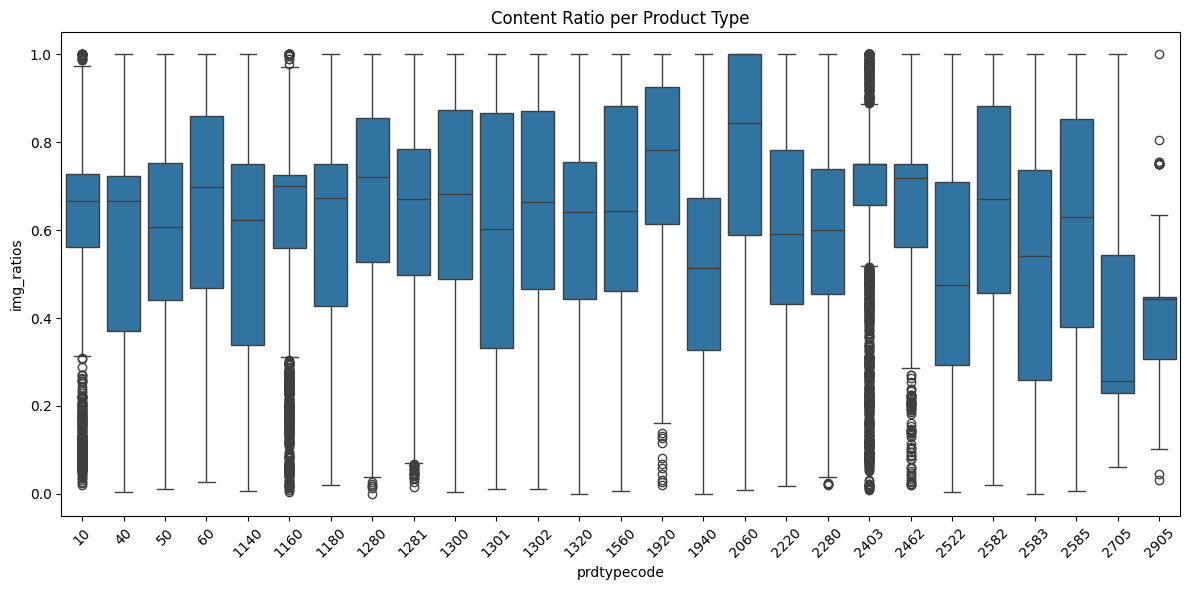

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="prdtypecode", y="img_ratios", data=df)
plt.title("Image Ratio per Product Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

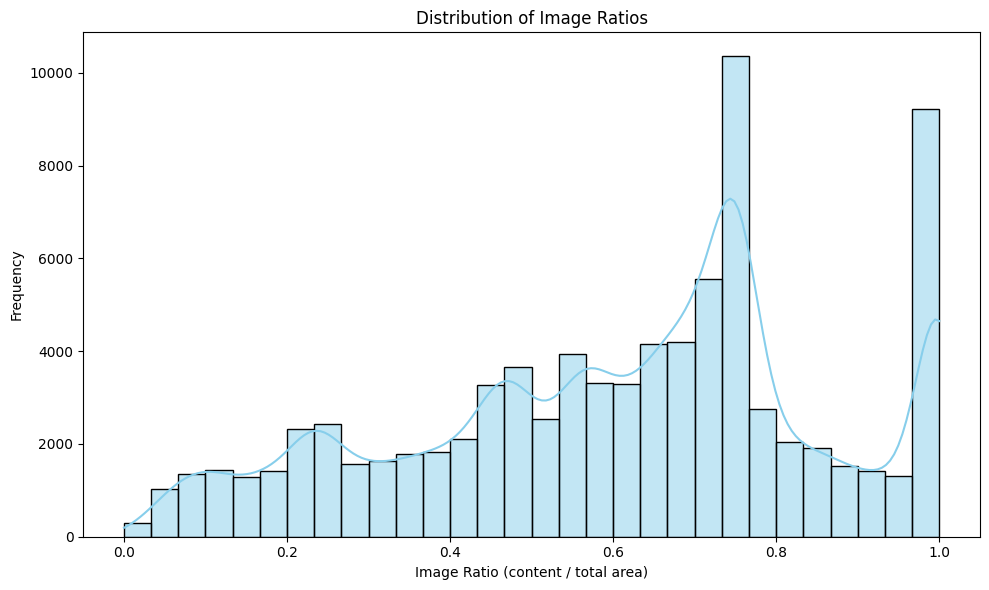

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df["img_ratios"], bins=30, kde=True, color="skyblue")
plt.title("Distribution of Image Ratios")
plt.xlabel("Image Ratio (content / total area)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [ ]:
lim = 0.2
product_stats = []
for product_type, group in df.groupby("prdtypecode"):
    product_percentage = len(group) / len(df) * 100
    avg_content_ratio = group["img_ratios"].mean()
    low_ratio_percentage = (group["img_ratios"] < lim).mean()
    product_stats.append([product_type, product_percentage, avg_content_ratio, low_ratio_percentage])

column_name = f"Low Ratio Percentage (<{lim})"
stats_df = pd.DataFrame(product_stats, columns=["Product Type", "% of Total Products", "Average Image Ratio", column_name])

stats_df

,Product Type,% of Total Products,Average Image Ratio,Low Ratio Percentage (<0.2)
0,10,3.669509,0.573373,0.184531
1,40,2.953507,0.568241,0.124003
2,50,1.979603,0.591647,0.075550
3,60,0.979792,0.662748,0.046875
4,1140,3.145461,0.545573,0.147885
5,1160,4.655189,0.600565,0.073362
6,1180,0.899713,0.592028,0.094241
7,1280,5.735079,0.680698,0.029979
8,1281,2.437703,0.638812,0.057005
9,1300,5.941165,0.665885,0.033102


## Modelling

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Filter based on image content ratio (img_ratios)
df = df[df["img_ratios"] >= 0.04].reset_index(drop=True)

le = LabelEncoder()
df["label"] = le.fit_transform(df["prdtypecode"])

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

train_df.to_csv("train_df.csv", index=False)
val_df.to_csv("val_df.csv", index=False)


In [ ]:
train_df.shape

(67606, 8)

In [ ]:
val_df.shape

(16902, 8)

In [ ]:
train_df.head()

,Unnamed: 0,text,imagename,len_char,len_word,prdtypecode,img_ratios,label
43376,43573,os noué denta fun au poulet lot de article réf...,image_1246397153_product_3798828314.jpg,168,26,2220,0.284292,17
53190,53434,techit lot de piquets pour bâche techit lot de...,image_1136544232_product_2332095811.jpg,290,52,2583,0.259688,23
45172,45380,queue billard animalia loup bce longueur jonct...,image_1125141387_product_2089381875.jpg,302,46,1301,0.586296,10
44245,44448,leitz pince agrafeuse juwel capacit d agrafage...,image_940532380_product_147743604.jpg,55,8,2522,0.243712,21
19008,19090,decoration de noel women watch christmas leath...,image_1317648193_product_4211183999.jpg,704,109,2060,0.475640,16


### BERT Model On Text + Images Input

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from transformers import TFDistilBertModel, DistilBertTokenizer
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, concatenate, Lambda



IMAGE_DIR = "images/image_train_cropped"
IMG_SIZE = (224, 224)
MAX_LEN = 128
BATCH_SIZE = 32
EPOCHS = 5

gpus = tf.config.list_physical_devices('GPU')
print("GPU(s) available:" if gpus else "No GPU found.", gpus)


GPU(s) available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
train_df = pd.read_csv("train_df_5k.csv")
val_df = pd.read_csv("val_df_1k.csv")


In [ ]:
# filter unusable data
train_df = train_df[train_df["img_ratios"] >= 0.04]
val_df = val_df[val_df["img_ratios"] >= 0.04]

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_texts(texts):
    return tokenizer(texts.tolist(), padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="np")

def load_image(imagename):
    try:
        path = os.path.join(IMAGE_DIR, f"{imagename}")
        img = load_img(path, target_size=IMG_SIZE)
        return img_to_array(img) / 255.0
    except:
        return None


In [ ]:
def prepare_inputs(df, print_every=100):
    total = len(df)
    print(f"Loading {total} images and tokenizing text...")

    image_arrays = []
    valid_rows = []

    for i, row in enumerate(df.itertuples(index=False), 1):
        if i % print_every == 0 or i == total:
            print(f"Processed {i}/{total} images...", flush=True)
        
        img = load_image(row.imagename)
        if img is not None:
            image_arrays.append(img)
            valid_rows.append(row)

    print("Done processing all images.")

    df_clean = pd.DataFrame(valid_rows)
    text_inputs = tokenize_texts(df_clean["text"])
    img_array = np.stack(image_arrays)

    return {
        "input_ids": text_inputs["input_ids"],
        "attention_mask": text_inputs["attention_mask"],
        "image_input": img_array,
    }, df_clean["label"].values


In [ ]:
train_inputs, y_train = prepare_inputs(train_df)

Loading 4995 images and tokenizing text...
Processed 100/4995 images...
Processed 200/4995 images...
Processed 300/4995 images...
Processed 400/4995 images...
Processed 500/4995 images...
Processed 600/4995 images...
Processed 700/4995 images...
Processed 800/4995 images...
Processed 900/4995 images...
Processed 1000/4995 images...
Processed 1100/4995 images...
Processed 1200/4995 images...
Processed 1300/4995 images...
Processed 1400/4995 images...
Processed 1500/4995 images...
Processed 1600/4995 images...
Processed 1700/4995 images...
Processed 1800/4995 images...
Processed 1900/4995 images...
Processed 2000/4995 images...
Processed 2100/4995 images...
Processed 2200/4995 images...
Processed 2300/4995 images...
Processed 2400/4995 images...
Processed 2500/4995 images...
Processed 2600/4995 images...
Processed 2700/4995 images...
Processed 2800/4995 images...
Processed 2900/4995 images...
Processed 3000/4995 images...
Processed 3100/4995 images...
Processed 3200/4995 images...
Proces

In [ ]:
val_inputs, y_val = prepare_inputs(val_df)

Loading 999 images and tokenizing text...
Processed 100/999 images...
Processed 200/999 images...
Processed 300/999 images...
Processed 400/999 images...
Processed 500/999 images...
Processed 600/999 images...
Processed 700/999 images...
Processed 800/999 images...
Processed 900/999 images...
Processed 999/999 images...
Done processing all images.


In [ ]:
num_classes = len(np.unique(y_train))

In [ ]:
text_input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
text_attention = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

# Load pretrained DistilBERT
bert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

def extract_cls_token(inputs):
    input_ids, attention_mask = inputs
    output = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    return output.last_hidden_state[:, 0, :]  # shape: (batch_size, hidden_dim)

# DistilBERT output is typically 768-dimensional
bert_output = Lambda(
    extract_cls_token,
    output_shape=(768,)
)([text_input_ids, text_attention])

text_branch = Dense(128, activation="relu")(bert_output)


I0000 00:00:1750790975.235878   11793 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5582 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTo

In [ ]:
# Image input
image_input = Input(shape=(*IMG_SIZE, 3), name="image_input")
x = Conv2D(32, 3, activation="relu")(image_input)
x = MaxPooling2D()(x)
x = Conv2D(64, 3, activation="relu")(x)
x = MaxPooling2D()(x)
x = Conv2D(128, 3, activation="relu")(x)
x = Flatten()(x)
image_branch = Dense(128, activation="relu")(x)

# Combine
combined = concatenate([text_branch, image_branch])
combined = Dense(128, activation="relu")(combined)
combined = Dropout(0.3)(combined)
output = Dense(num_classes, activation="softmax")(combined)

model = tf.keras.Model(inputs=[text_input_ids, text_attention, image_input], outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 222, 222,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 111, 111,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 54, 54,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 52, 52,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 768)       │          0 │ input_ids[0][0],  │
│                     │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 346112)    │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     98,432 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │ 44,302,464 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 27)        │      3,483 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 44,530,523 (169.87 MB)

 Trainable params: 44,530,523 (169.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# train
history = model.fit(
    train_inputs, y_train,
    validation_data=(val_inputs, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/5


I0000 00:00:1750790983.734534   12815 service.cc:152] XLA service 0x78fb780161e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750790983.734575   12815 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2025-06-24 21:49:43.922980: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-24 21:49:43.992458: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert
I0000 00:00:1750790984.928716   12815 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-24 21:49:46.233579: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 240 bytes spill stores, 240 byte

45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.0902 - loss: 3.2081

2025-06-24 21:49:59.670400: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert
2025-06-24 21:50:01.604626: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 240 bytes spill stores, 240 bytes spill loads

2025-06-24 21:50:01.978853: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 888 bytes spill stores, 888 bytes spill loads

2025-06-24 21:50:02.106047: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 916 bytes spill stores, 908 bytes spill loads

2025-06-24 21:50:02.451491: I external/local_xla/xla/stream_executor/cuda/subprocess_

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.0901 - loss: 3.2069

2025-06-24 21:50:11.983258: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert
2025-06-24 21:50:13.151228: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3657', 8 bytes spill stores, 8 bytes spill loads

2025-06-24 21:50:16.659493: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert
2025-06-24 21:50:18.305812: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 240 bytes spill stores, 240 bytes spill loads

2025-06-24 21:50:18.305854: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Regist

46/46 ━━━━━━━━━━━━━━━━━━━━ 44s 597ms/step - accuracy: 0.0901 - loss: 3.2058 - val_accuracy: 0.1000 - val_loss: 3.0337
Epoch 2/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.1361 - loss: 3.0187 - val_accuracy: 0.1600 - val_loss: 2.9161
Epoch 3/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.1650 - loss: 2.9029 - val_accuracy: 0.2000 - val_loss: 2.8305
Epoch 4/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.1959 - loss: 2.8142 - val_accuracy: 0.2300 - val_loss: 2.7369
Epoch 5/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.2332 - loss: 2.7344 - val_accuracy: 0.2733 - val_loss: 2.6898


In [ ]:
print("Evaluation:")
val_preds = model.predict(val_inputs).argmax(axis=1)
print(classification_report(y_val, val_preds))


Evaluation:


2025-06-24 21:50:42.163745: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert


 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

2025-06-24 21:50:45.865362: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 421ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.23      0.59      0.33        27
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00         4
           4       0.19      0.22      0.20        23
           5       0.40      0.81      0.54        27
           6       0.50      0.04      0.08        24
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         9
           9       0.00      0.00      0.00         5
          10       0.15      0.50      0.23        12
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00        11
          16       0.00      0.00      0

/home/eagle/.pyenv/versions/3.12.7/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/eagle/.pyenv/versions/3.12.7/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/eagle/.pyenv/versions/3.12.7/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

### SVM and Random Forest Models on Text Input

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from datetime import datetime
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
MAX_TFIDF_FEATURES = 3000
SAVE_DIR = "text_img_ratio_results"
os.makedirs(SAVE_DIR, exist_ok=True)

train_path = "train_df_5k.csv"
val_path = "val_df_1k.csv"

In [ ]:
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)

train_df = train_df[train_df["img_ratios"] >= 0.04]
val_df = val_df[val_df["img_ratios"] >= 0.04]

In [ ]:
y_train = train_df["label"].values
y_val = val_df["label"].values

# Mapping: label -> prdtypecode
label_to_prd = train_df.drop_duplicates("label").set_index("label")["prdtypecode"].to_dict()
with open(os.path.join(SAVE_DIR, "label_to_prdtypecode.json"), "w") as f:
    json.dump(label_to_prd, f)

In [ ]:
tfidf = TfidfVectorizer(max_features=MAX_TFIDF_FEATURES, stop_words="english", min_df=5)
X_train_text = tfidf.fit_transform(train_df['text'])
X_val_text = tfidf.transform(val_df['text'])

X_train_num = train_df["img_ratios"].values
X_val_num = val_df["img_ratios"].values

In [ ]:
X_train = np.hstack((X_train_text.toarray(), X_train_num.reshape(-1, 1)))
X_val = np.hstack((X_val_text.toarray(), X_val_num.reshape(-1, 1)))

In [ ]:
# Save path
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = os.path.join(SAVE_DIR, f"run_{timestamp}")
os.makedirs(save_path, exist_ok=True)

In [ ]:
# Save vectorizer
joblib.dump(tfidf, os.path.join(save_path, "tfidf_vectorizer.pkl"))

['text_img_ratio_results/run_20250625_124951/tfidf_vectorizer.pkl']

In [ ]:
def evaluate_and_save(model, X_val, y_val, label_to_prd, model_name, save_path):
    y_pred = model.predict(X_val)

    # Convert to original prdtypecodes
    y_true_prd = [label_to_prd[label] for label in y_val]
    y_pred_prd = [label_to_prd[label] for label in y_pred]

    cm = confusion_matrix(y_true_prd, y_pred_prd, labels=sorted(set(y_true_prd)))
    report = classification_report(y_true_prd, y_pred_prd, output_dict=True)

    df_cm = pd.DataFrame(cm, index=[f"Actual {c}" for c in sorted(set(y_true_prd))],
                         columns=[f"Predicted {c}" for c in sorted(set(y_pred_prd))])
    df_report = pd.DataFrame(report).transpose()

    df_cm.to_csv(os.path.join(save_path, f"{model_name}_confusion_matrix.csv"))
    df_report.to_csv(os.path.join(save_path, f"{model_name}_classification_report.csv"))

    print(f"\n{model_name} Evaluation Done")
    print(df_report.round(2))

    joblib.dump(model, os.path.join(save_path, f"{model_name}_model.pkl"))

    if "accuracy" not in df_report.index:
        df_report = df_report.drop("accuracy")

    # Only keep classes (numeric prdtypecodes), remove 'macro avg', etc.
    df_report_class = df_report[df_report.index.str.isnumeric()]
    df_report_class["f1-score"] = df_report_class["f1-score"].astype(float)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=df_report_class.index, y="f1-score", data=df_report_class, palette="viridis")
    plt.title(f"F1 Scores per Class for {model_name}")
    plt.xlabel("prdtypecode")
    plt.ylabel("F1 Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f"{model_name}_f1_scores.png"))
    plt.close()

    # visualize and save confusion matrix heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f"{model_name}_confusion_matrix.png"))
    plt.close()


In [ ]:
# Random forest
print("\nTraining Random Forest...")
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

evaluate_and_save(rf, X_val, y_val, label_to_prd, "random_forest", save_path)



Training Random Forest...

random_forest Evaluation Done
              precision  recall  f1-score  support
10                 0.39    0.49      0.43    37.00
40                 0.47    0.38      0.42    37.00
50                 0.63    0.70      0.67    37.00
60                 0.97    0.84      0.90    37.00
1140               0.61    0.59      0.60    37.00
1160               0.50    0.84      0.63    37.00
1180               0.82    0.49      0.61    37.00
1280               0.64    0.24      0.35    37.00
1281               0.69    0.59      0.64    37.00
1300               0.64    0.76      0.69    37.00
1301               0.88    0.78      0.83    37.00
1302               0.84    0.73      0.78    37.00
1320               0.75    0.41      0.53    37.00
1560               0.68    0.57      0.62    37.00
1920               0.83    0.81      0.82    37.00
1940               0.60    0.76      0.67    37.00
2060               0.66    0.73      0.69    37.00
2220               0.86 

/tmp/ipykernel_5886/2400992360.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_report_class["f1-score"] = df_report_class["f1-score"].astype(float)
/tmp/ipykernel_5886/2400992360.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_report_class.index, y="f1-score", data=df_report_class, palette="viridis")


In [ ]:
# SVM
print("\n🧪 Training Linear SVM...")
svm = LinearSVC(C=1.0, loss='squared_hinge', max_iter=5000)
svm.fit(X_train, y_train)
evaluate_and_save(svm, X_val, y_val, label_to_prd, "svm", save_path)



🧪 Training Linear SVM...

svm Evaluation Done
              precision  recall  f1-score  support
10                 0.21    0.27      0.24    37.00
40                 0.53    0.43      0.48    37.00
50                 0.65    0.86      0.74    37.00
60                 0.94    0.89      0.92    37.00
1140               0.68    0.68      0.68    37.00
1160               0.81    0.78      0.79    37.00
1180               0.51    0.51      0.51    37.00
1280               0.46    0.43      0.44    37.00
1281               0.53    0.43      0.48    37.00
1300               0.66    0.78      0.72    37.00
1301               0.82    0.89      0.86    37.00
1302               0.79    0.81      0.80    37.00
1320               0.65    0.46      0.54    37.00
1560               0.68    0.57      0.62    37.00
1920               0.73    0.86      0.79    37.00
1940               0.84    0.86      0.85    37.00
2060               0.66    0.62      0.64    37.00
2220               0.82    0.89    

/tmp/ipykernel_5886/2400992360.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_report_class["f1-score"] = df_report_class["f1-score"].astype(float)
/tmp/ipykernel_5886/2400992360.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_report_class.index, y="f1-score", data=df_report_class, palette="viridis")
